# CNN - 가위바위보

[https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors) 에서 배포하는 데이터셋

아래 URL을 통해 기본 파일 정리가 수행된 파일을 내려 받는다.

> [https://drive.google.com/file/d/1x6YsEBCSuxAKbmUbF-U0ntXoNwELoTVr/view?usp=sharing](https://drive.google.com/file/d/1x6YsEBCSuxAKbmUbF-U0ntXoNwELoTVr/view?usp=sharing)

## #01. 준비작업 

### [1] 패키지 참조


In [2]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[scatterd] >WARNING> From c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



### [2] 데이터셋 준비하기

#### (1) 파일 압축 해제

데이터셋을 캐글로부터 다운로드 받은 후 적절한 위치에 압축을 해제한다.

압축을 해제하면 cats 폴더와 dogs 폴더에 각각 5000장의 이미지가 포함되어 있다.


In [3]:
# 압축파일의 경로
workspace_dir = "D://"
file_path = os.path.join(workspace_dir, "rock-paper-scissors.zip")

# 압축을 해제할 경로
extract_dir = os.path.join(workspace_dir, "rock-paper-scissors")

# 해당 폴더가 없다면 폴더를 생성하고 파일의 압축을 해제
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

    zip_ref = zipfile.ZipFile(file_path, "r")
    zip_ref.extractall(extract_dir)
    zip_ref.close()

#### (2) 임의의 이미지 확인

#####  이미지

실행시마다 표시 이미지가 랜덤하게 바뀐다.


In [4]:
subdir = os.listdir(extract_dir)
subdir

['paper', 'rock', 'scissors']

D://rock-paper-scissors\paper


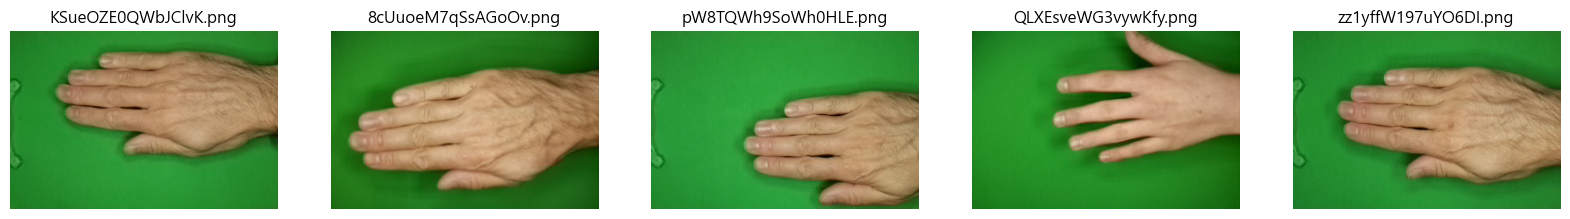

D://rock-paper-scissors\rock


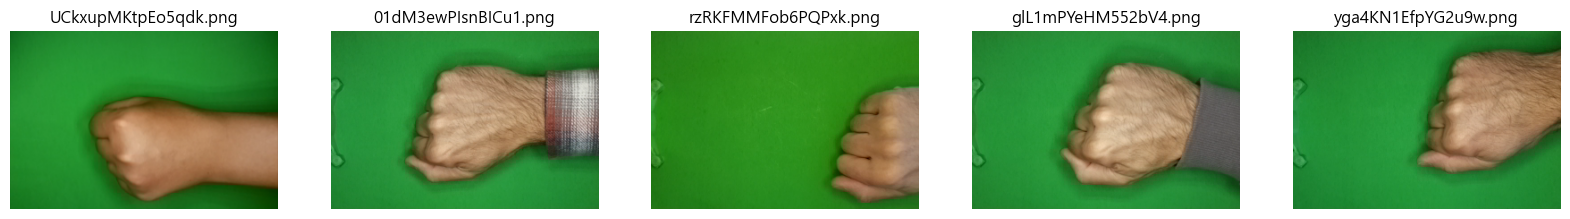

D://rock-paper-scissors\scissors


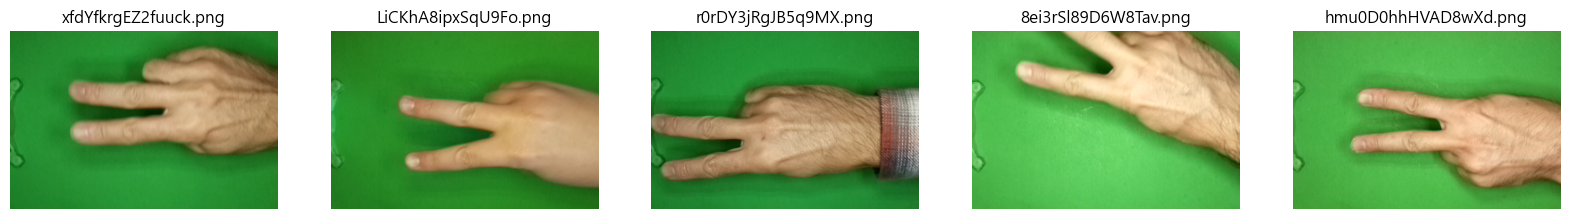

In [5]:
for s in subdir:
    path = os.path.join(extract_dir, s)
    print(path)
    
    image_list = os.listdir(path)
    image_count = len(image_list)
    
    rand = np.random.random_integers(0, image_count -1, 5)
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 3), dpi=100)
    
    for i  in range(0, len(ax)):
        file_path = os.path.join(path, image_list[rand[i]])
        img = load_image(file_path)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(image_list[rand[i]])
        
    plt.show()
    plt.close()

## #02. 이미지 데이터 전처리

### [1] 이미지 전처리기 생성


In [6]:
image_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


### [2] 이미지 데이터 전처리 수행

#### (1) 훈련용 이미지 데이터 생성


In [7]:
classes = os.listdir(extract_dir)
classes

['paper', 'rock', 'scissors']

In [8]:
train_set = image_gen.flow_from_directory(
    extract_dir,
    classes=classes,
    batch_size=16,
    class_mode='categorical',
    target_size=(64, 64),
    shuffle=True,
    color_mode='rgb',
    seed=get_random_state(),
    subset='training')

train_set.class_indices

Found 1751 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

#### (2) 검증용 데이터 생성


In [9]:
test_set = image_gen.flow_from_directory(
    extract_dir,
    classes=classes,
    batch_size=16,
    class_mode='categorical',
    target_size=(64, 64),
    shuffle=True,
    color_mode='rgb',
    seed=get_random_state(),
    subset='validation')

test_set.class_indices

Found 437 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

## #03. 훈련 모델 적합

### [1] 모델 정의하기


In [10]:
model = tf_create(
    layer=[
        {
            'type':'conv2d',
            'filters':16,
            'kernel_size':6,
            'padding': 'same',
            'input_shape':(64, 64, 3),
        },
        {'type': 'batchnorm'},
        {'type': 'activation', 'function':'relu'},
        {'type': 'maxpooling', 'pool_size':(2, 2)},
        {'type': 'dropout', 'rate':0.1},
        
        {
            'type':'conv2d',
            'filters':32,
            'kernel_size':5,
            'padding': 'same'
           
        },
        {'type': 'batchnorm'},
        {'type': 'activation', 'function':'relu'},
        {'type': 'maxpooling', 'pool_size':(2, 2)},
        {'type': 'dropout', 'rate':0.1},
        {
            'type':'conv2d',
            'filters':64,
            'kernel_size':4,
            'padding': 'same',
            
        },
        {'type': 'batchnorm'},
        {'type': 'activation', 'function':'relu'},
        {'type': 'maxpooling', 'pool_size':(2, 2)},
        {'type': 'dropout', 'rate':0.1},
        {
            'type':'conv2d',
            'filters':128,
            'kernel_size':3,
            'padding': 'same',
            
        },
        {'type': 'batchnorm'},
        {'type': 'activation', 'function':'relu'},
        {'type': 'maxpooling', 'pool_size':(2, 2)},
        {'type': 'dropout', 'rate':0.1},
        
        {'type':'flatten'},
        {'type':'dense', 'units': 64},
        {'type':'batchnorm'},
        {'type':'activation', 'function':'relu'},
        {'type':'dense', 'units':3},
        {'type':'batchnorm'},
        {'type':'activation', 'function':'softmax'}],
    
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

model.summary()
        

[scatterd] >WARNING> From c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

[scatterd] >WARNING> From c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:979: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



{'type': 'conv2d', 'filters': 16, 'kernel_size': 6, 'padding': 'same', 'input_shape': (64, 64, 3)}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'conv2d', 'filters': 32, 'kernel_size': 5, 'padding': 'same'}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'conv2d', 'filters': 64, 'kernel_size': 4, 'padding': 'same'}


[scatterd] >WARNING> From c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'conv2d', 'filters': 128, 'kernel_size': 3, 'padding': 'same'}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'maxpooling', 'pool_size': (2, 2)}
{'type': 'dropout', 'rate': 0.1}
{'type': 'flatten'}
{'type': 'dense', 'units': 64}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'relu'}
{'type': 'dense', 'units': 3}
{'type': 'batchnorm'}
{'type': 'activation', 'function': 'softmax'}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        1744      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 16)        64        
 Normalization)                                                  
              

### [2] 학습하기


In [11]:
%%time

batch_size=16

result = tf_train(
    model=model,
    x_train=train_set,
    x_test=test_set,
    epochs=1000,
    step_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
    verbose=1
)

tf_result(result)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 3, in <module>
  File "c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycallgraphix\wrapper.py", line 49, in function_wrapper_for_node_storage
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jihwan\Desktop\hossam-data-helper\hossam\tensor.py", line 359, in tf_train
    history = model.fit(
              ^^^^^^^^^^
  File "c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\Jihwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__

## #04. 학습 결과 확인

### [1] 검증 데이터의 라벨 확인


### [2] 검증 데이터에 대한 예측값


### [3] 혼동 행렬


## #05. 학습 결과 적용

### [1] 임의의 이미지 가져오기


### [2] 이미지 전처리


#### [3] 예측 결과 확인
